# Cyberbullying Classification

### 1. The degree of aggressivity & Negativity

### 2. Personnalization
    - Depency tree, establish the subject, object, complement, aux
    - Also, tell the (person 1st, 2nd, 3rd) of the subject and the object. 
    - Identify what are they accuse from 
    - Identify who’s being targeted (Lexicon or wordnet)
    - Established if the aux is directed to the object  (Establishing intention)
### 3. Harms inflicted and to who
    - Now, using the complement (output of dependency tree), we can map these to threats
    - We need wordnet to identify threat. (Actually better lexicon than word net)
    - To object refers to what category? race, nationality, religion, color, gender, 



Set your environment
- source spacy/bin/activate (Bash)
- get back to your base: deactivate (Bash)

You have to be in anaconda3 interpreter

# Import data

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()

macbook = ('/Users/philippebeliveau/Desktop/Notebook/Winter_2024/Text_mining/Git_MiningRepository/Text_miningProject/Notebook/cyberbullying_tweets.csv')

mac_mini = ('/Users/philippebeliveau/Desktop/Notebook_Jupyter_R/Winter_2024/Text_mining/Project/Text_miningProject/Notebook/cyberbullying_tweets.csv')

df = pd.read_csv(mac_mini)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


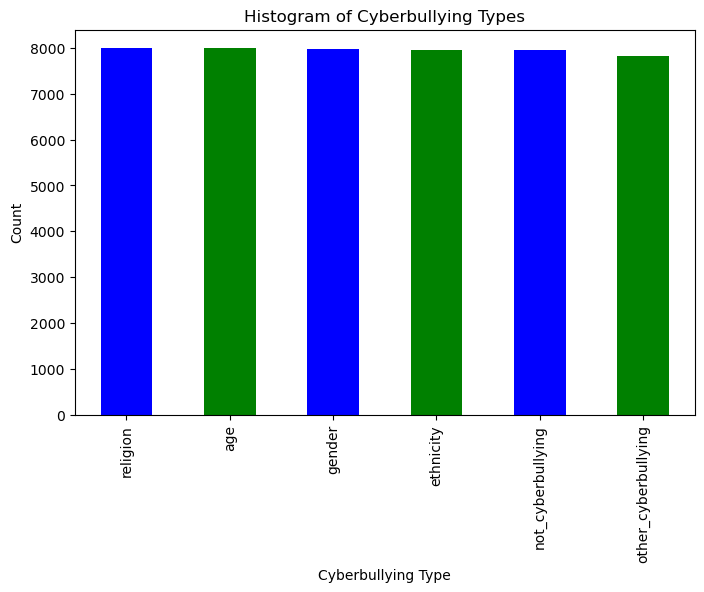

In [33]:
# Plotting the histogram
plt.figure(figsize=(8, 5))
df['cyberbullying_type'].value_counts().plot(kind='bar', color=['blue', 'green'])

plt.title('Histogram of Cyberbullying Types')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Count')
plt.show()

In [34]:
# Get unique categories of cyberbullying type
categories = df['cyberbullying_type'].unique()

# Iterate over each category
for category in categories:
    # Filter the dataset for the current category
    category_tweets = df[df['cyberbullying_type'] == category]['tweet_text'].head(5)
    
    # Print the category name
    print(f"{category.capitalize()} Tweets:")
    
    # Print the tweets for the current category
    for i, tweet in enumerate(category_tweets):
        print(f"{i+1}. {tweet}")
    
    # Add a newline for separation between categories
    print()


Not_cyberbullying Tweets:
1. In other words #katandandre, your food was crapilicious! #mkr
2. Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
3. @XochitlSuckkks a classy whore? Or more red velvet cupcakes?
4. @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
5. @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.

Gender Tweets:
1. rape is real..zvasiyana nema jokes about being drunk or being gay or being lesbian...rape is not ones choice or wish..thtz where the sensitivity is coming from
2. You never saw any celebrity say anything like this for Obama: B Maher Incest Rape 'Joke' S Colbert Gay 'joke' K Griffin beheading 'joke'
3. @ManhattaKnight I mean he's gay, but he uses gendered slurs and makes rape jokes
4. RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @_mecaesmal  feminazi
5. Rape is rape. And the fact that I re

# Preprocessing
- What about the links & Hashtag?
- Do some processing for name entities

N-gram features, which consider sequences of words, have proven to be highly predictive in identifying hate speech. Furthermore, character n-gram features are particularly effective as they address spelling variations by capturing the similarity between canonical spellings. In fact, character n-grams frequently outperform token n-grams in hate speech detection.
Also, other surface features such as the frequency of URLs, punctuation usage, comments, token lengths, capitalization, and non-alphanumeric tokens offer valuable insights.

## Tokenization 
https://spacy.io/usage/linguistic-features#tokenization

https://spacy.io/api/tokenizer

### Dependency parser
https://spacy.io/usage/linguistic-features#sbd-parser

### Rule base matching
https://spacy.io/usage/rule-based-matching#fuzzy

Hashtag: https://spacy.io/usage/rule-based-matching#example3

In [106]:
# Construction 1
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

# Construction 2
from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

In [118]:
#doc = nlp("I don't believe Iranians are gay, but they uses gendered slurs and makes rape jokes")

# for token in doc:
#     print(token.text)

# Statistical sentence segmenter
nlp = spacy.load("en_core_web_sm")
nlp.enable_pipe("senter")
doc = nlp("I don't believe Iranians are gay, but they uses gendered slurs and makes rape jokes")
nlp.enable_pipe("senter")
for sent in doc.sents:
    print(sent.text)

# for chunk in doc.noun_chunks:
#     print(chunk.text, chunk.root.text, chunk.root.dep_,
#             chunk.root.head.text)

I don't believe Iranians are gay, but they uses gendered slurs and makes rape jokes


# Part 2 - Critique vs Insult

In [1]:
#Importing libraries
import nltk
import spacy
import numpy as np
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

# Word generalization 
Given the data sparsity problem inherent in hate speech detection, word generalization techniques are crucial. Word clustering, such as Brown clustering, enables the representation of sets of words as additional features. Latent Dirichlet Allocation (LDA) is another powerful technique that groups words into topics, providing a deeper understanding of the underlying content. Word embeddings and paragraph embeddings further enhance hate speech detection by capturing semantic relationships and contextual information.


### Word net

What other tool could be use instead of Wordnet?

Disambiguation
- Do we have any case of word that we should disambiguate?


### Lexicons 
Identify good verb and adjective that identify to this lexicons
1. Hate speech lexicon https://github.com/bgmartins/hate-speech-lexicons/tree/master

### Name entities
Entity Linking: https://spacy.io/usage/linguistic-features#entity-linking

Named Entity Recognition NER using spaCy | NLP | Part 4

- https://towardsdatascience.com/named-entity-recognition-ner-using-spacy-nlp-part-4-28da2ece57c6#:~:text=Text%20Processing%20using%20spaCy%20%7C%20NLP%20Library&text=Named%20Entity%20Recognition%20NER%20works,values%2C%20percentage%2C%20codes%20etc.
- Could be use to identify the groups being targeted? 

The named entities are categories that answer these contextual questions: 
- Proper nouns such as people names, organizations, companies, etc. 
- Locations 
- Quantities, distances or values 
- Dates

https://support.prodi.gy/t/entity-recognition-vs-text-classification/532/2

In [29]:
# Example 
en_EntNom = "Julie, the arabs are the ones that are going to push the real change. they are the ones in power, generally. we need their help."

In [30]:
#On charge le texte dans le format  de Spacy et on utilise la fonction de visualisation displacy pour surligné les ENs
doc = nlp(en_EntNom)
displacy.render(doc, style="ent")

If you put Julie! instead of Julie, the model won't recognize it as an entity

In [31]:
# Here is a function that tokenize the entities and allow us to replace the entities with their function 
#We execute the function on our example sentence, replacing the entities with their function. 
# We can then generalize all entities and reduce the noise in our data, for example!

def replace_ent(doc_text):
    #Search for the list of entities named in the text with their type
    entity_dict = {}
    for ent in doc_text.ents:
        entity_dict[ent.text] = ent.label_
    
    token_list = []
    #We tokenize the text with the entity condition
    for token in doc_text:
        if token.text in entity_dict:
            token_list.append(entity_dict[token.text])
        else:
            token_list.append(token.text)
            
    return token_list

print(replace_ent(doc))

['PERSON', ',', 'the', 'NORP', 'are', 'the', 'ones', 'that', 'are', 'going', 'to', 'push', 'the', 'real', 'change', '.', 'they', 'are', 'the', 'ones', 'in', 'power', ',', 'generally', '.', 'we', 'need', 'their', 'help', '.']


#### Wordnet

In [16]:
#We start by importing the Wordnet databse from NLTK
from nltk.corpus import wordnet

#We can print the different meanings of the word "program" - the synset represent the hypernyms of the word program
syns = wordnet.synsets("program")
print(syns[0].name(), '|', syns[1].name(), '|', syns[2].name(), '|', syns[3].name())

In [ ]:
#If you want to look for the set of synonyms and antonyms for the word "kind"
synonyms = []
antonyms = []

for syn in wordnet.synsets("kind"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())

print(set(synonyms))
print(set(antonyms))

In [ ]:
#Finally, we can calculate similarity scores between words based on their proximity in Wordnet
w1 = wordnet.synset('ship.n.01')
w2 = wordnet.synset('boat.n.01')
print(w1.wup_similarity(w2))

### Notes
Question:
- Use of Leveinstein distance? We would have to build a reference dictionnary which would be too much

#### Normalization
To create the normalization function, we need to add the merge_entities tool to our Spacy nlp pipeline nlp.add_pipe('merge_entities') 

- Texte d'origine :  Last night I went to the National Bank to look at a mortgage.
- Texte normalisé :  Last night I went to National Bank of Canada to look at a mortgage .

#### More advance methods for NER 
The simplest NER  systems are based on a  set of regular expressions,  which are used to obtain patterns of characters that are probably named entities. State-of-the-art systems are often hybrids*, made up of three different components: 
- Regex markers, which are always used to identify our recurring patterns 
- Statistical learning based on lexicographic (capitalization), syntactic (POS, position of the
element in the sentence, etc.) and semantic (importance of the element) variables. 
- Elements from external systems, such as reference dictionaries (Wikipedia) 

# Sentiment analysis

A multi-step approach involves examining the presence of positive, negative, and neutral words, while a single-step approach focuses on the polar intensity of utterances, using tools like SentiStrength. 
- http://sentistrength.wlv.ac.uk/
- https://pypi.org/project/PySentiStrength/
- https://github.com/bobvdvelde/SentiStrength_for_python


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
- https://vadersentiment.readthedocs.io/en/latest/
specifically attuned to sentiments expressed in social media. I



# Linguistic features
Linguistic features, such as part-of-speech tags and syntactical dependency relationships, can offer insights into the offensive level of an utterance. Combining n-gram analysis with Part-of-Speech (POS) tagging enriches the hate speech detection process. Syntactical dependency relationships and offensive level scoring enhance the accuracy of classification models. These linguistic features provide deeper insights into the structure and intent of hate speech expressions.
### Dependency tree
https://spacy.io/usage/linguistic-features
Dependency grammar analyze the functional role of words in addition to their syntactic role

On the other hand, discourse theory looks at sequence of sentences.
 
https://spacy.io/usage/rule-based-matching#models-rules-pos-dep
### POS tagging
With POS tagging, we recover the syntactic categories of words. As a reminder, syntactic categories include nouns, verbs, numbers (NUM) and punctuation (PUNCT).
- helps in identifying distinction by identifying one bear as a noun and the other as a verb
- Word-sense disambiguation
    - "The bear is a majestic animal"
    - "Please bear with me"
- Sentiment analysis
- Question answering
- Fake news and opinion spam detection

How to acces the categories: https://notebook.community/VictorQuintana91/Thesis/notebooks/002_pos_tagging


In [193]:
#We use the spacy loader with our previously defined example (cell 3)
 
en_EntNom = "Hindus were and are getting killed by Muslims terriorists in Kashmir"
en_EntNom = "I believe Iranians are gay, but they uses gendered slurs and makes rape jokes"

doc = nlp(en_EntNom)

#We define a function that scans the text object and prints the text (token), its dependency relationship and the word with which it is linked.
def dep_tree(doc_text): 
    for token in doc_text:
        print( token.morph.get('Person'))
data = dep_tree(doc)

# token.text," : " ,token.lemma_," : ", token.pos_," : ", token.tag_," : ", token.dep_," : ",
#                 token.shape_," : ", token.is_alpha, " : ",token.is_stop, ":", token.morph, ":",


['1']
[]
[]
[]
[]
[]
[]
['3']
['3']
[]
[]
[]
['3']
[]
[]


In [151]:
#We define a function that scans the text object and prints the text (token), its dependency relationship and the word with which it is linked.
test =  "Christians were and are getting killed by Muslims terrorists in Kashmir"
test = nlp(test)
def dep_tree(doc_text): 
    for token in doc_text:
        print(token.text," : ",token.dep_, '|', token.head)
        
dep_tree(test)

Christians  :  nsubj | were
were  :  ROOT | were
and  :  cc | were
are  :  aux | killed
getting  :  auxpass | killed
killed  :  conj | were
by  :  agent | killed
Muslims  :  compound | terrorists
terrorists  :  pobj | by
in  :  prep | killed
Kashmir  :  pobj | in


In [108]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)

I I nsubj believe
Iranians Iranians nsubj are
he he nsubj uses
gendered slurs slurs dobj uses
rape jokes jokes dobj makes


In [69]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Christians nsubj were AUX []
were ROOT were AUX [Christians, and, killed]
and cc were AUX []
are aux killed VERB []
getting auxpass killed VERB []
killed conj were AUX [are, getting, by, in]
by agent killed VERB [Muslims terrorists]
Muslims terrorists pobj by ADP []
in prep killed VERB [Kashmir]
Kashmir pobj in ADP []


In [118]:
# Finding a verb with a subject from below — good
from spacy.symbols import nsubj, VERB, acomp
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{believe, uses}


In [120]:
# Finding a verb with a subject from above — less good
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break
verbs

[believe, uses]

In [282]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a VADER sentiment analyzer object
analyzer = SentimentIntensityAnalyzer()

# Initialize lists to store data
data = []

TEXTS = [
"I believe Russians are beautiful, but Superman is a bitch, I will kill him"
]
   
"I mean he's gay, but he uses gendered slurs and makes rape jokes"
"I am going to fuck him up"

for idx, doc in enumerate(nlp.pipe(TEXTS)):
    for token in doc:
        #if token.ent_type_ in ("NORP", "PERSON", "GPE"):
        # Check if the token is a subject or complement
        if token.dep_ in ("nsubj", "aux", "acomp", "attr", "conj"):
            subjects = [w.text for w in token.head.lefts if w.dep_ in ("nsubj")]
            aux = [w.text for w in token.head.lefts if w.dep_ in ('aux')]
            objects = [w.text for w in token.head.rights if w.dep_ == "dobj"]
            complement = [w.text for w in token.head.rights if w.dep_ in ("acomp", "attr", 'dobj', 'conj',
                                                                          'VERB')]
            person = [token.morph.get("Person") for i in subjects]
            person_obj = [token.morph.get("Person") for i in objects]
            if subjects or objects and complement:
                for subject in subjects:
                    for comp in complement:
                        subject_ent = [ent.label_ for ent in doc.ents if ent.text == subject]
                        object_ent = [ent.label_ for ent in doc.ents if ent.text == object]
                        # comp_ent = [ent.label_ for ent in doc.ents if ent.text == comp]
                        # Get the named entity text for the token
                        named_entity_text = [ent.label_ for ent in doc.ents]
                        # Perform sentiment analysis on the complement using VADER
                        sentiment_score = analyzer.polarity_scores(comp)["compound"]
                        # Append data to list
                        data.append({"Text": TEXTS[idx], "Subject": subject, "Object": object, "Aux": aux,
                                      "Subject Named Entity Text": subject_ent[0] if subject_ent else None,
                                      "Object Named Entity Text": object_ent[0] if object_ent else None,
                                      "Complement": comp,
                                      "Sentiment_SUBJ": sentiment_score, "Pronous": person})
# "Complement Named Entity Text": comp_ent[0] if comp_ent else None
# Create DataFrame
df = pd.DataFrame(data)
df

,Text,Subject,Object,Aux,Subject Named Entity Text,Object Named Entity Text,Complement,Sentiment_SUBJ,Pronous
0,"I believe Russians are beautiful, but Superman...",I,him,[],None,None,kill,-0.6908,[[1]]
1,"I believe Russians are beautiful, but Superman...",Russians,him,[],NORP,None,beautiful,0.5994,[[]]
2,"I believe Russians are beautiful, but Superman...",Russians,him,[],NORP,None,beautiful,0.5994,[[]]
3,"I believe Russians are beautiful, but Superman...",Superman,him,[],PERSON,None,bitch,-0.5859,[[]]
4,"I believe Russians are beautiful, but Superman...",Superman,him,[],PERSON,None,bitch,-0.5859,[[]]
5,"I believe Russians are beautiful, but Superman...",I,him,[will],None,None,him,0.0000,[[1]]
6,"I believe Russians are beautiful, but Superman...",I,him,[will],None,None,him,0.0000,[[]]
7,"I believe Russians are beautiful, but Superman...",I,him,[],None,None,kill,-0.6908,[[]]


In [261]:
#We define a function that scans the text object and prints the text (token), its dependency relationship and the word with which it is linked.
test ="I believe Russians are beautiful and Justin Trudeau is a bitch, I will beat him"

"I mean he's gay, but he uses gendered slurs and makes rape jokes"
test = nlp(test)
    # for token in doc_text:
    #     print(token.text," : ",token.dep_, '|', token.head)
for token in test:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
        [child for child in token.children])

token.children


I nsubj believe VERB []
believe ccomp beat VERB [I, are]
Russians nsubj are AUX []
are ccomp believe VERB [Russians, beautiful, and, is]
beautiful acomp are AUX []
and cc are AUX []
Justin compound Trudeau PROPN []
Trudeau nsubj is AUX [Justin]
is conj are AUX [Trudeau, bitch]
a det bitch NOUN []
bitch attr is AUX [a]
, punct beat VERB []
I nsubj beat VERB []
will aux beat VERB []
beat ROOT beat VERB [believe, ,, I, will, him]
him dobj beat VERB []


Text: The original word text.
Lemma: The base form of the word.
POS: The simple UPOS part-of-speech tag.
Tag: The detailed part-of-speech tag.
Dep: Syntactic dependency, i.e. the relation between tokens.
Shape: The word shape – capitalization, punctuation, digits.
is alpha: Is the token an alpha character?
is stop: Is the token part of a stop list, i.e. the most common words of the language?

In [105]:
# To access the element at which he is related
doc[4].dep

type = doc[4].head
type.dep


408

In [223]:
#We define a function that scans the text object and prints the text (token), its dependency relationship and the word with which it is linked.
test =      "I am going to fuck him up"
test = nlp(test)
#This part of the library is imported for graphic visualization only.
from spacy import displacy

#For our doc object, we display the dependency graph, which allows us to better understand/analyze these relationships manually
displacy.render(test, style="dep")

### Syntax references
These relations link a  referent and an antecedent via a reference expression.

- Co-reference: A reference in a sentence to the same entity - " Michael Jackson died in 2009. The  King of Pop  was very influential".
- The anaphora: This is a reference to an expression already used in the discourse, but which is not necessarily the same entity - "The  house is dilapidated. Its roof  is falling apart"

The aim is to identify the elements in the text that create these syntactic links. These are usually semantic repetitions

#### Coreference resolution 
Once the candidates have been identified, other systems (such as networks) are created to  determine the antecedent/referent relationships between the various entities

#### Rhetoric tree
Identify categories in the sentence: the result, the explanation, parallelism, elaboration, etc

- Elaboration relations are characterized by
meronymies and textual implications
(collocation). 
- List relations are easily detected using
synonyms and hyponyms.

What could be interesting is the list relations, although I am not sure what it is about.

# Knowledge-based features
Detecting hate speech requires more than observing specific keywords. Incorporating one-world knowledge, such as distinguishing between hateful and benign expressions, broadens the scope of analysis. Furthermore, focusing on specific subtypes of hate speech, such as anti-LGBT discourse, can be accomplished using resources like ConceptNet, which encodes concepts connected by relations.

- https://conceptnet.io/
- https://github.com/eclarson/MachineLearningNotebooks/blob/master/14.%20ConceptNet.ipynb